# Analysis

This notebook contains the analysis of the data tracked on
[Weights & Biases](https://wandb.ai/).


## Setup

---

We will first setup everything so that we can easily analyse the experiment
results. This includes importing the necessary libraries, setting paths, loading
the experiment results from W&B.


In [37]:
# ruff: noqa
%load_ext autoreload
%autoreload 2

# Bult-in modules
import os
import sys

sys.path.insert(0, "..")

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# External modules
# - Data Representation
import pandas as pd
import numpy as np

# - Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as pn

# - Machine Learning
import torch

# - Experiment Configuration and Logging
import wandb

# Custom modules
from utils import eval_utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Setup of global variables
ROOT_DIR = os.path.dirname(os.path.abspath("."))
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

METHODS = ["baseline", "baseline_pp", "matchingnet", "protonet", "maml"]
METHODS_WITH_SOT = []
for method in METHODS:
    METHODS_WITH_SOT.append(method)
    METHODS_WITH_SOT.append(method + "_sot")

STYLED_METHODS = ["Baseline", "Baseline++", "MatchingNet", "ProtoNet", "MAML"]
STYLED_METHODS_WITH_SOT = []
for method in STYLED_METHODS:
    STYLED_METHODS_WITH_SOT.append(method)
    STYLED_METHODS_WITH_SOT.append(method + " (SOT)")

styled_methods_dict = dict(zip(METHODS, STYLED_METHODS))


def get_name(name, sot=False):
    return styled_methods_dict[name] + (" (SOT)" if sot else "")

In [39]:
# Settings
sns.set_style("dark")
colorstyle = "RdBu"
sns.set_palette(colorstyle)

In [40]:
# Initialize wandb
WANDB_PROJECT = "few-shot-benchmark"
WANDB_ENTITY = "metameta-learners"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

## Experiment 1: Benchmark

---

All models on all datasets with and without SOT for fixed few-shot learning
setting (5-way 5-shot).


### Loading Experiment Data


In [41]:
# Get all runs for experiment `benchmark`
GROUP = "tuned-benchmark"

group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 187 runs


Next, we'll load all runs from the given experiment group into a single
dataframe.


In [42]:
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 187 runs.


info                config            \
                                         name    runtime    dataset    method   
id                                                                              
xhag25gy  protonet-swissprot-sot-5-way-5-shot  41.468315  swissprot  protonet   
l44f5r3n  protonet-swissprot-sot-5-way-5-shot  59.784709  swissprot  protonet   
sfge218r  protonet-swissprot-sot-5-way-5-shot  68.427992  swissprot  protonet   
dmdcuf2o  protonet-swissprot-sot-5-way-5-shot  52.142571  swissprot  protonet   
mrol34qm  protonet-swissprot-sot-5-way-5-shot  37.431727  swissprot  protonet   

                               eval                            ...             \
         use_sot n_way n_shot epoch test/acc_std train/acc_ci  ...   test/acc   
id                                                             ...              
xhag25gy    True     5      5    11     8.079373     0.528487  ...  80.520000   
l44f5r3n    True     5      5    20     1.754220     0.057454  ...  99.206667   
sfge218r    True     5      5    22     6.043913     0.294206  ...  87.533333   
dmdcuf2o    True     5      5    15     1.424718     0.093008  ...  99.513333   
mrol34qm    True     5      5    11     8.605298     0.688453  ...  76.046667   

                                                                      \
         train/loss val/acc_ci val/acc_std test/acc_ci train/acc_std   
id                                                                     
xhag25gy   0.244571   0.623834    7.796295    0.646484      6.604712   
l44f5r3n   0.027856   0.129876    1.623111    0.140367      0.718022   
sfge218r   0.078707   0.576652    7.206651    0.483614      3.676804   
dmdcuf2o    0.03927   0.184714    2.308439    0.114001      1.162354   
mrol34qm   0.271612   0.739377    9.240289    0.688567      8.603865   

         hyperparam                                            
                 lr sot_reg sot_sinkhorn_iter sot_dist_metric  
id                                                             
xhag25gy     0.0010     1.0                10       euclidean  
l44f5r3n     0.0010     0.1                10       euclidean  
sfge218r     0.0010     1.0                10          cosine  
dmdcuf2o     0.0010     0.1                10          cosine  
mrol34qm     0.0005     1.0                10       euclidean  

[5 rows x 22 columns]

### Grouping

Each experiment is uniquely identified by the following parameters:

- `dataset`: The dataset used (`swissprot`, `tabula_muris`)
- `method`: The model used (`baseline`, `baseline_pp`, `protonet`,
  `matchingnet`, `maml`)
- `use_sot`: Whether to include the SOT module (`True`, `False`)
- `n_way`: The number of classes in each episode
- `n_shot`: The number of support samples per class in each episode

For each experiment setting, there are multiple trained models because of
hyper-parameter tuning. We will group the runs by the above parameters and only
use the best-performing model on the validation set for the following analysis.


In [43]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

# Let's also save two separate dataframes for the two different datasets
df_best_runs_tm = df_best_runs[df_best_runs[("config", "dataset")] == "tabula_muris"]
df_best_runs_sp = df_best_runs[df_best_runs[("config", "dataset")] == "swissprot"]

df_best_runs.head()

✅ Filtered to 20 best runs.


info                    config  \
                                               name     runtime       dataset   
l44f5r3n        protonet-swissprot-sot-5-way-5-shot   59.784709     swissprot   
mb6s32it  baseline_pp-tabula_muris-sot-5-way-5-shot  283.423143  tabula_muris   
9mzhwegk      baseline_pp-tabula_muris-5-way-5-shot  287.713995  tabula_muris   
pklw5upz     baseline_pp-swissprot-sot-5-way-5-shot  339.399153     swissprot   
g07tittq         baseline_pp-swissprot-5-way-5-shot  358.645061     swissprot   

                                            eval                            \
               method use_sot n_way n_shot epoch test/acc_std train/acc_ci   
l44f5r3n     protonet    True     5      5    20     1.754220     0.057454   
mb6s32it  baseline_pp    True     5      5     6    11.680571     0.916270   
9mzhwegk  baseline_pp   False     5      5     8    10.939177     0.491274   
pklw5upz  baseline_pp    True     5      5     7     9.024254     1.009687   
g07tittq  baseline_pp   False     5      5    12     8.674038     0.367225   

          ...                                                           \
          ...   test/acc train/loss val/acc_ci val/acc_std test/acc_ci   
l44f5r3n  ...  99.206667   0.027856   0.129876    1.623111    0.140367   
mb6s32it  ...  82.760000   3.137616   1.102896   13.783333    0.934640   
9mzhwegk  ...  81.880000   0.262760   0.901880   11.271153    0.875316   
pklw5upz  ...  64.613333   3.982392   0.896979   11.209898    0.722091   
g07tittq  ...  64.120000   0.774483   0.968879   12.108471    0.694068   

                       hyperparam                                            
         train/acc_std         lr sot_reg sot_sinkhorn_iter sot_dist_metric  
l44f5r3n      0.718022      0.001     0.1                10       euclidean  
mb6s32it     11.450995      0.001     0.1                10          cosine  
9mzhwegk      6.139649      0.001     0.1                10          cosine  
pklw5upz     12.618461      0.001     0.1                10          cosine  
g07tittq      4.589360      0.001     0.1                10          cosine  

[5 rows x 22 columns]

In [44]:
# Parse the results for both the report
tm_res = utils.exp2results(df_best_runs_tm)
sp_res = utils.exp2results(df_best_runs_sp)

# Create a MultiIndex for the results where the first level is the dataset
tm_res = tm_res.set_index("Method")
tm_res.index = pd.MultiIndex.from_product([["TM"], tm_res.index])
sp_res = sp_res.set_index("Method")
sp_res.index = pd.MultiIndex.from_product([["SP"], sp_res.index])

# Concatenate the results
df_results = pd.concat([tm_res, sp_res])

# Get the latex
latex = utils.exp2latex(df_results)

# Save the latex
with open(os.path.join(TABLE_DIR, "tuned-benchmark.tex"), "w") as f:
    f.write(latex)

df_results

Acc          w/ SOT   Diff
   Method                                       
TM B       $90.7 \pm 0.7$  $86.3 \pm 0.9$  -4.84
   B++     $81.9 \pm 0.9$  $82.8 \pm 0.9$   1.07
   MAML    $92.8 \pm 0.5$  $99.2 \pm 0.1$   6.86
   MT      $84.6 \pm 0.8$  $99.7 \pm 0.1$  17.90
   PT      $87.1 \pm 0.8$  $98.6 \pm 0.2$  13.23
SP B       $69.2 \pm 0.7$  $55.7 \pm 0.8$ -19.55
   B++     $64.1 \pm 0.7$  $64.6 \pm 0.7$   0.77
   MAML    $68.7 \pm 0.7$  $98.0 \pm 0.2$  42.79
   MT      $68.2 \pm 0.8$  $99.8 \pm 0.1$  46.46
   PT      $63.5 \pm 0.7$  $99.2 \pm 0.1$  56.13

### Train / Val / Test Performance for all models

Here, we plot a simple bar plot for all methods (5 methods, each with and
without SOT) on all three splits (train, val, test). Performances are shown in
two separate plots for Swissprot and Tabula Muris


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


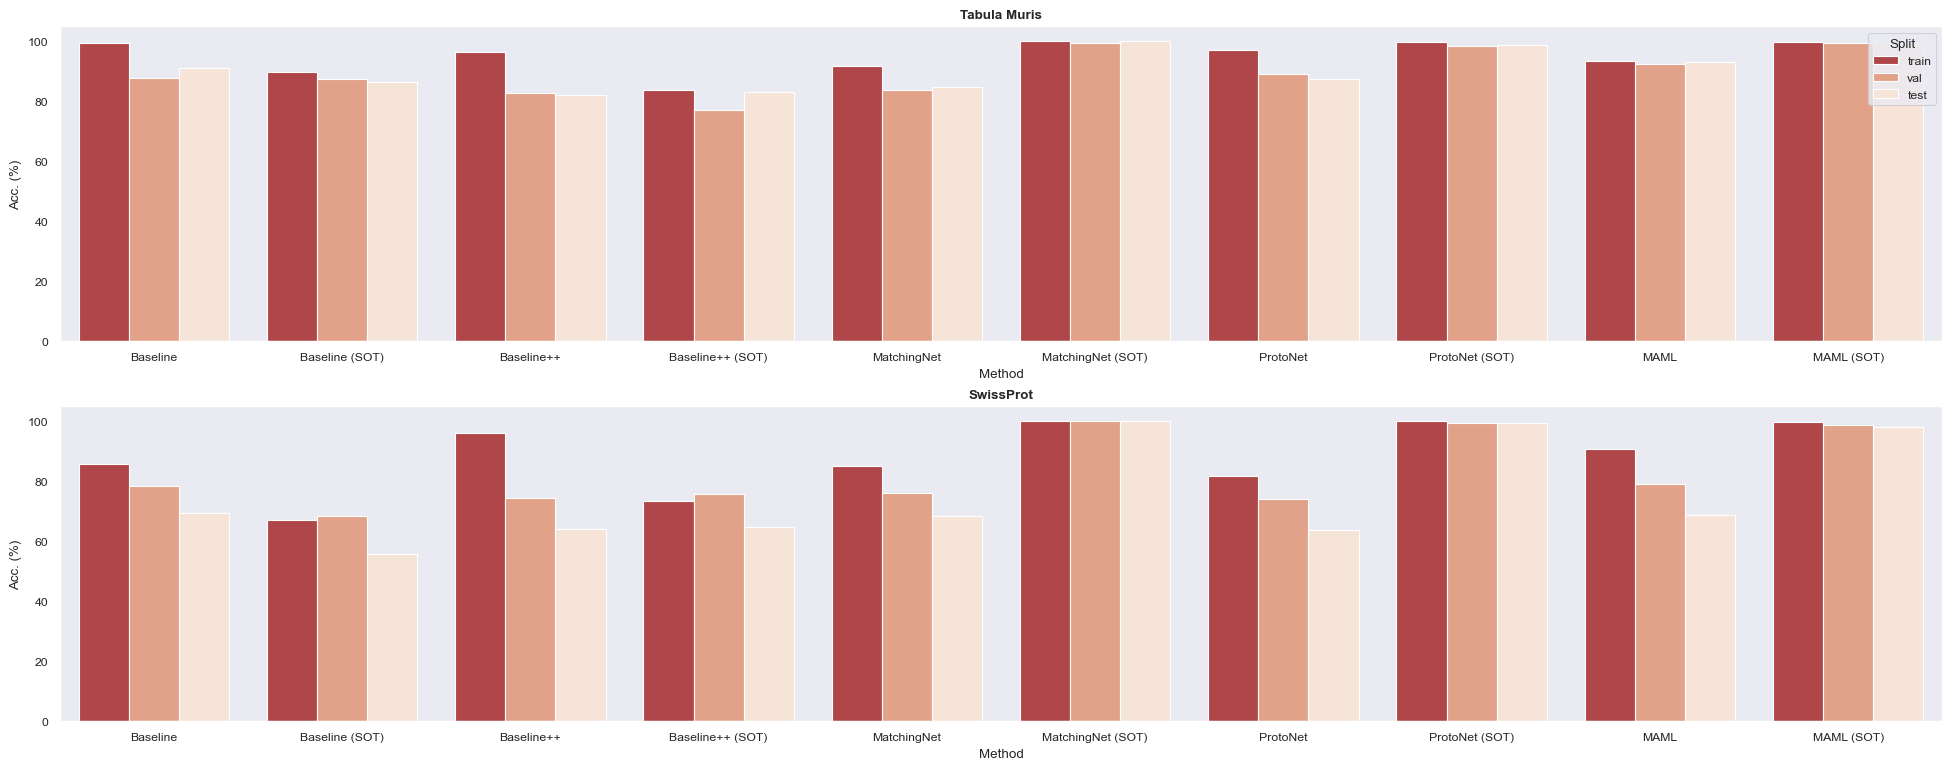

In [45]:
# Performance by split for all methods
fig, axs = plt.subplots(nrows=2, figsize=(20, 8))
fig.tight_layout(pad=3.0)


def pivot_acc(df):
    tmp = []
    for i, best_model in df.iterrows():
        for split in ["train", "val", "test"]:
            method_name = get_name(
                best_model[("config", "method")], best_model[("config", "use_sot")]
            )
            tmp.append(
                {
                    "method": method_name,
                    "split": split,
                    "acc": best_model[("eval", f"{split}/acc")],
                }
            )
    return pd.DataFrame(tmp)


sns.barplot(
    pivot_acc(df_best_runs_tm),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[0],
)
sns.barplot(
    pivot_acc(df_best_runs_sp),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[1],
)
# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("Split")
axs[1].get_legend().remove()

for ax in axs:
    ax.set_xlabel("Method")
    ax.set_ylabel("Acc. (%)")

fig.savefig(os.path.join(FIGURE_DIR, "benchmark-split-perf.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Performance by method with and without SOT

Here, we compare the performance of the different methods with and without SOT.
The left subplot shows the test performance on the Tabula Muris dataset, while
the right subplot shows the test performance on the Swissprot dataset.


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


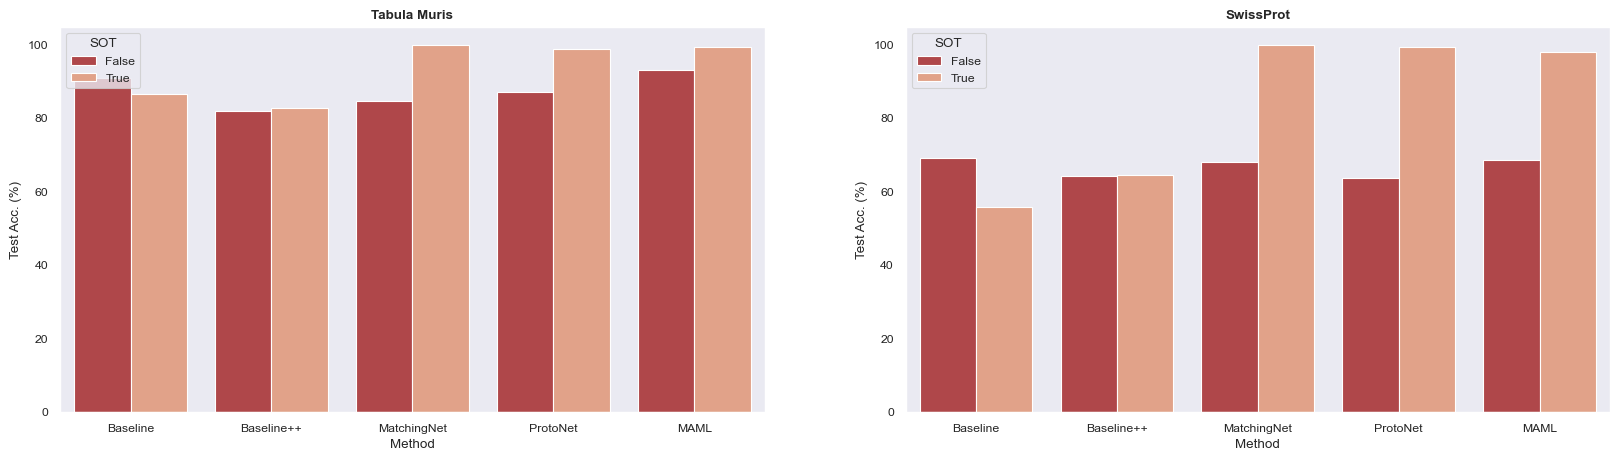

In [46]:
# Performance by method with and without SOT
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

sns.barplot(
    df_best_runs_tm,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    order=METHODS,
    ax=axs[0],
)

sns.barplot(
    df_best_runs_sp,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    ci="sd",
    order=METHODS,
    ax=axs[1],
)

# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("SOT")
axs[1].get_legend().set_title("SOT")

# Set axis labels
axs[0].set_xticklabels([get_name(name.get_text()) for name in axs[0].get_xticklabels()])
axs[1].set_xticklabels([get_name(name.get_text()) for name in axs[1].get_xticklabels()])

for ax in axs:
    ax.set_ylabel("Test Acc. (%)")
    ax.set_xlabel("Method")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "benchmark-perf.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Performance by different hyperparameters

In [10]:
df_runs = utils.load_to_df(group_runs)

In [11]:
param_cols = df_runs[("hyperparam")].columns.tolist()
param_tuples = [('hyperparam', param) for param in param_cols]
param_tuples.append(('config', 'method'))
param_tuples.append(('config', 'use_sot'))
param_tuples

[('hyperparam', 'lr'),
 ('hyperparam', 'sot_reg'),
 ('hyperparam', 'sot_dist_metric'),
 ('config', 'method'),
 ('config', 'use_sot')]

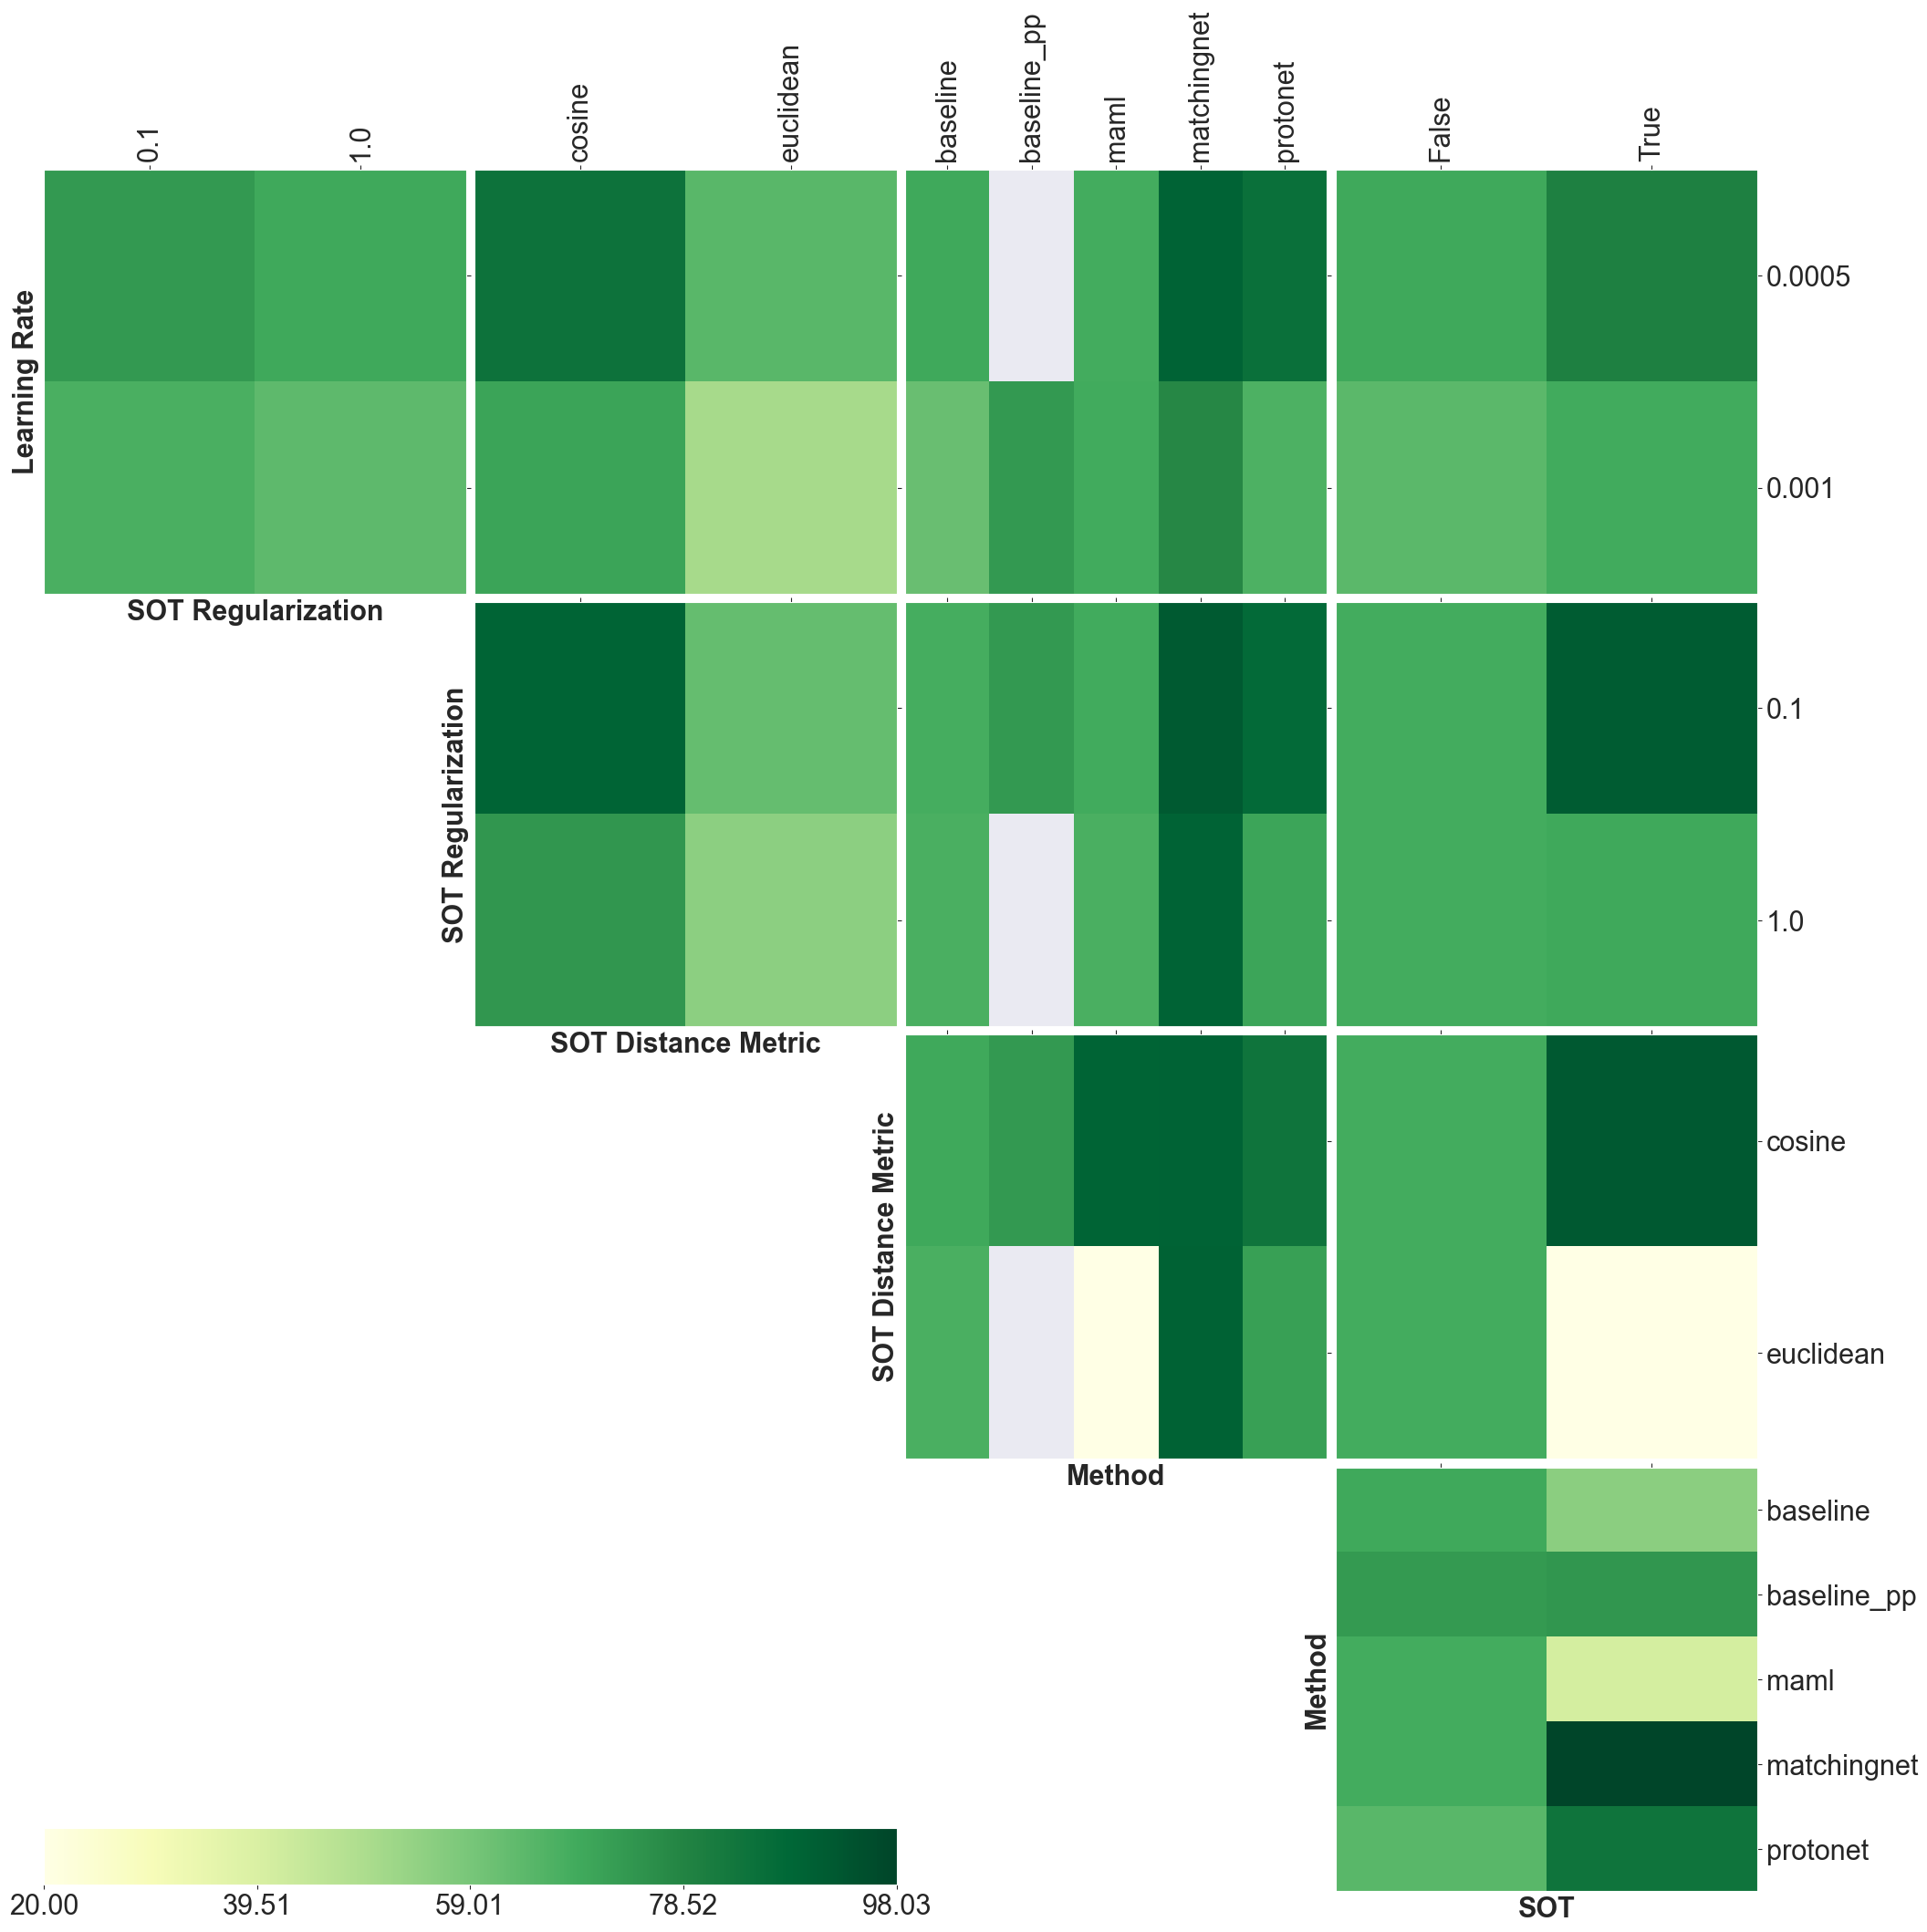

In [12]:
utils.grid(df_runs, param_tuples, metric='median', cmap='YlGn')  #vmin, vmax automatically set

## Experiment 2: Way-Shot Analysis

---

Varying the number of shots per class.


In [47]:
# Load experiment data for `way-shot` experiment
GROUP = "tuned-way-shot"

# Filter runs by group
group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 140 runs


In [48]:
# Load runs into dataframe
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 140 runs.


info                   config  \
                                            name    runtime       dataset   
id                                                                          
jt2ta23d  protonet-tabula_muris-sot-2-way-1-shot  10.070405  tabula_muris   
fskxgzyn  protonet-tabula_muris-sot-2-way-1-shot   8.644238  tabula_muris   
n0k58ypm  protonet-tabula_muris-sot-2-way-1-shot  21.065443  tabula_muris   
mjoyg3fp  protonet-tabula_muris-sot-2-way-1-shot  11.459806  tabula_muris   
ylnioeug  protonet-tabula_muris-sot-2-way-1-shot  17.867123  tabula_muris   

                                               eval               \
            method use_sot n_way n_shot test/acc_ci test/acc_std   
id                                                                 
jt2ta23d  protonet    True     2      1    0.586472     7.329374   
fskxgzyn  protonet    True     2      1    0.638598     7.980810   
n0k58ypm  protonet    True     2      1    0.356760     4.458575   
mjoyg3fp  protonet    True     2      1    0.809778    10.120112   
ylnioeug  protonet    True     2      1    0.415188     5.188770   

                        ...                                         \
         train/acc_std  ... epoch    val/acc   test/acc val/acc_ci   
id                      ...                                          
jt2ta23d      6.467354  ...     9  97.083333  96.716667   0.546577   
fskxgzyn      7.176331  ...     7  95.366667  95.800000   0.721034   
n0k58ypm      3.740729  ...    25  98.216667  98.433333   0.366564   
mjoyg3fp      6.720098  ...    10  95.616667  95.500000   0.712492   
ylnioeug      4.912456  ...    17  97.316667  97.900000   0.505857   

                                 hyperparam                            \
         train/acc_ci train/loss         lr sot_reg sot_sinkhorn_iter   
id                                                                      
jt2ta23d     0.517496   0.035695     0.0010     0.1                10   
fskxgzyn     0.574226   0.136274     0.0005     1.0                10   
n0k58ypm     0.299321   0.029194     0.0005     0.1                10   
mjoyg3fp     0.537720   0.072955     0.0005     1.0                10   
ylnioeug     0.393078   0.064350     0.0005     0.1                10   

                          
         sot_dist_metric  
id                        
jt2ta23d          cosine  
fskxgzyn       euclidean  
n0k58ypm       euclidean  
mjoyg3fp          cosine  
ylnioeug          cosine  

[5 rows x 22 columns]

Only keep the best run for each experiment configuration. This only has an
effect if hyperparameter tuning was performed.


In [49]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

df_best_runs.head()

✅ Filtered to 50 best runs.


info                   config  \
                                             name    runtime       dataset   
n0k58ypm   protonet-tabula_muris-sot-2-way-1-shot  21.065443  tabula_muris   
bxwl3jba       protonet-tabula_muris-2-way-1-shot   6.392499  tabula_muris   
r1crrk2z   protonet-tabula_muris-sot-2-way-5-shot  14.182222  tabula_muris   
vkq5kto7       protonet-tabula_muris-2-way-5-shot  10.240377  tabula_muris   
ewoc79bt  protonet-tabula_muris-sot-2-way-10-shot  24.640196  tabula_muris   

                                               eval               \
            method use_sot n_way n_shot test/acc_ci test/acc_std   
n0k58ypm  protonet    True     2      1    0.356760     4.458575   
bxwl3jba  protonet   False     2      1    1.320183    16.498855   
r1crrk2z  protonet    True     2      5    0.298654     3.732403   
vkq5kto7  protonet   False     2      5    0.819714    10.244294   
ewoc79bt  protonet    True     2     10    0.190361     2.379017   

                        ...                                         \
         train/acc_std  ... epoch    val/acc   test/acc val/acc_ci   
n0k58ypm      3.740729  ...    25  98.216667  98.433333   0.366564   
bxwl3jba     13.336500  ...     9  90.416667  88.433333   1.194885   
r1crrk2z      3.203991  ...    10  98.933333  99.050000   0.283228   
vkq5kto7      8.472685  ...    11  95.433333  94.766667   0.841047   
ewoc79bt      1.810770  ...    16  99.433333  99.583333   0.190683   

                                 hyperparam                            \
         train/acc_ci train/loss         lr sot_reg sot_sinkhorn_iter   
n0k58ypm     0.299321   0.029194     0.0005     0.1                10   
bxwl3jba     1.067142   1.338327     0.0010     0.1                10   
r1crrk2z     0.256373   0.022313     0.0005     0.1                10   
vkq5kto7     0.677956   0.175386     0.0010     0.1                10   
ewoc79bt     0.144892   0.014239     0.0005     0.1                10   

                          
         sot_dist_metric  
n0k58ypm       euclidean  
bxwl3jba          cosine  
r1crrk2z       euclidean  
vkq5kto7          cosine  
ewoc79bt       euclidean  

[5 rows x 22 columns]

### Shot-Way-Analysis

Display the test/acc as a function of the number of shots per class and the
number of classes to distinguish between the different methods for ProtoNet
without and with SOT.


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


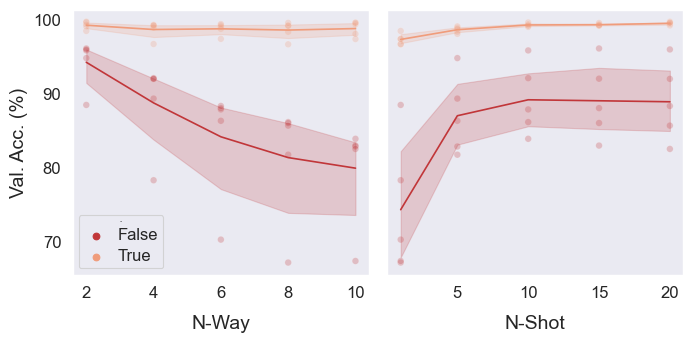

In [50]:
# Set context to paper
sns.set_context("paper")
sns.set_style("dark")

# Plot test/acc vs. n_shot for SOT and non-SOT methods
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), sharey=True)

# test/acc ~ n_shot
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=True,
    ax=axs[0],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[0],
)

# test/acc ~ n_way
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=False,
    ax=axs[1],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[1],
)

# Set label size
labsize = 14

# Set title of the legend, adjust font size
axs[0].get_legend().set_title("SOT", prop={"size": 1})
for t in axs[0].get_legend().texts:
    t.set_fontsize(12)

# Set axis labels
axs[0].set_xlabel("N-Way", size=labsize)
axs[1].set_xlabel("N-Shot", size=labsize)

# Add padding between label of x-axis and tick labels
axs[0].xaxis.labelpad = 10
axs[1].xaxis.labelpad = 10

# Set axis labels
axs[0].set_ylabel("Val. Acc. (%)", size=labsize)
axs[1].set_ylabel("")

# Make the ticks descroptors bigger
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)

# Set the tight layout
fig.tight_layout(pad=1.0)

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "way-shot.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Experiment 3: SOT Interaction

---

We found that SOT interacts in an interesting manner with the re-embedding
modules in distance-based few-shot learners like `ProtoNet` and `MatchingNet`.
In this experiment, we investigate this interaction in more detail. To do this,
we trained `MatchingNet` by enabling the SOT and LSTM embedding for support and
query samples and observe the performance on the test set.


In [51]:
# Experiments
GROUP = "sot-interaction"

# Filter runs by group
group_runs = {
    run.id: run for run in runs if run.group == GROUP and run.state == "finished"
}
print(f"✅ Loaded {len(group_runs)} runs")

✅ Loaded 8 runs


In [52]:
# Load runs into dataframe
df_runs = utils.load_to_df(group_runs.values())

# Load additional information
embed_support = [run.config["method"]["embed_support"] for run in group_runs.values()]
embed_query = [run.config["method"]["embed_query"] for run in group_runs.values()]
df_runs[("config", "embed_support")] = embed_support
df_runs[("config", "embed_query")] = embed_query
print(f"✅ Added meta-information.")

✅ Added meta-information.


✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


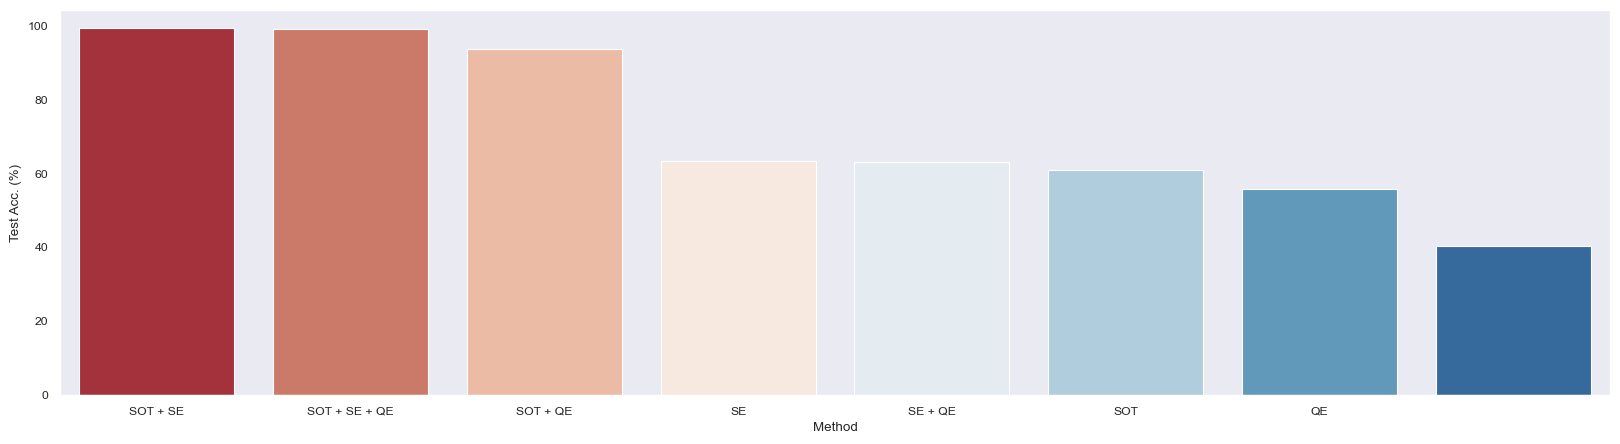

In [53]:
# Plot test/acc vs. name
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(
    data=df_runs.sort_values(by=("eval", "test/acc"), ascending=False),
    x=("info", "name"),
    y=("eval", "test/acc"),
    palette="RdBu",
)
ax.set_xlabel("Method")
ax.set_ylabel("Test Acc. (%)")

# Set axis labels
labels = []
for exp in [l.get_text().split("-")[1::2] for l in ax.get_xticklabels()]:
    name = []
    if exp[0] == "true":
        name.append("SOT")
    if exp[1] == "true":
        name.append("SE")
    if exp[2] == "true":
        name.append("QE")

    labels.append(" + ".join(name))
ax.set_xticklabels(labels)

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-interaction.pdf"),
            bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


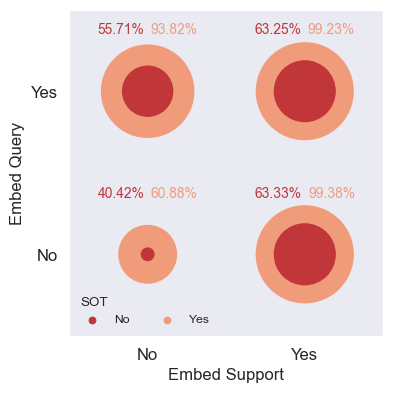

In [66]:
# Scatterplot of interaction between support, query and SOT embeddings
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    df_runs,
    x=("config", "embed_support"),
    y=("config", "embed_query"),
    hue=("config", "use_sot"),
    size=("eval", "test/acc"),
    sizes=(100, 5000),
    linewidth=0,
)

# Set label size
labsize = 12

# Set the labels and ticks of the axes
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"])
ax.set(
    xlabel="Embed Support",
    ylabel="Embed Query",
)

# Set x and y axis labels size
ax.xaxis.label.set_size(labsize)
ax.yaxis.label.set_size(labsize)


# Add the accuarcy as text to the scatterplot
for i, row in df_runs.iterrows():

    # Get sot flag
    is_sot = row[("config", "use_sot")]

    # Decide on the color of the text based on the SOT flag, use 
    color = sns.color_palette()[1] if is_sot else sns.color_palette()[0] 

    # Define the offset of the text
    y_offset = 0.35
    x_offset = 0.17 if is_sot else -0.17

    # Add accuracies horizontally centered above the scatterplot
    ax.text(
        x=row[("config", "embed_support")] + x_offset,
        y=row[("config", "embed_query")] + y_offset,
        s=f"{row[('eval', 'test/acc')]:.2f}%",
        color=color,
        horizontalalignment="center",
        size=10,
    )

# Make the ticks descroptors bigger
ax.tick_params(labelsize=labsize)

# Tight layout
fig.tight_layout(pad=1.0)

# Remove the legend
ax.get_legend().remove()

# Add a new custom legend
handles, labels = ax.get_legend_handles_labels()
labels = ["No", "Yes"]
handles = [handles[1], handles[2]]
legend = ax.legend(handles, labels, title="SOT", loc="lower left", ncol=2);

# Align the legend title to the left
legend._legend_box.align = "left"

# Remove the legend border and background
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_facecolor("none")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-interaction-scatter.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

✅ Saved figure to /Users/ludekcizinsky/Dev/personal/few-shot-benchmark/figures.


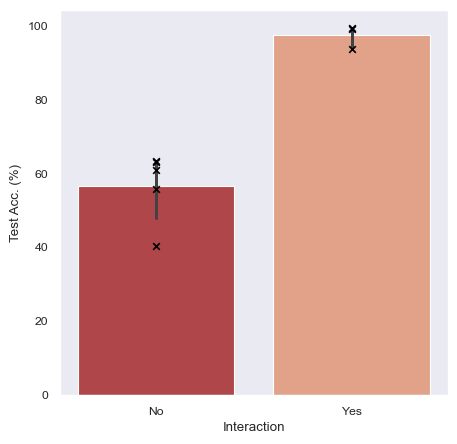

In [55]:
def is_interaction(row):
    support, query, sot = (
        row[("config", "embed_support")],
        row[("config", "embed_query")],
        row[("config", "use_sot")],
    )
    if (support | query) & sot:
        return True
    else:
        return False


df_runs[("config", "interaction")] = df_runs.apply(is_interaction, axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    df_runs,
    x=("config", "interaction"),
    y=("eval", "test/acc"),
    ax=ax,
)
ax.scatter(
    x=df_runs[("config", "interaction")],
    y=df_runs[("eval", "test/acc")],
    c="black",
    alpha=1,
    marker="x",
    zorder=100,
)

ax.set_xticklabels(["No", "Yes"])
ax.set_xlabel("Interaction")
ax.set_ylabel("Test Acc. (%)")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-interaction-2.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Experiment 4: Understanding model performance

---

The goal of this section will be to compare the improvements of the SOT feature
transform. We will try to understand the improvements by looking at:

- **Embeddings during forward-pass**. Visualise the embeddings of support and
  query samples during episodes with and without SOT enabled.
- **Visualise the self-optimal transport plan.** Visualise the self-optimal
  transport plan for a few episodes via a heat map.
- **Understand model prediction patterns and errors.** Visualise the model
  predictions and errors for a few episodes with and without SOT enabled.

To get started, we will load two pre-trained models from the benchmarking
experiment. We will use two instances of `protonet` that were both trained on
the `tabula_muris` dataset. The first model was trained with the default
configuration, while the second model was trained with the same configuration
but with the `use_sot` flag set to `True`.


In [ ]:
# Experiments
GROUP = "model-behaviour"

# Filter runs by group
runs = [run for run in runs if run.group == GROUP and run.state == "finished"]
print(f"✅ Loaded {len(runs)} runs")

# Load runs into dataframe
df_runs = utils.load_to_df(runs)

df_runs.head()

In [ ]:
# Initialise data loaders and model
models = []
for run in runs:
    # Load data loaders and model
    train_loader, val_loader, test_loader, model = utils.init_all(run)
    models.append(model)

print(f"✅ Initialised data loader and model.")

In [ ]:
# Download artifact (model weights)
for run in runs:
    utils.download_artifact(
        api,
        wandb_entity=WANDB_ENTITY,
        wandb_project=WANDB_PROJECT,
        artifact_dir=ARTIFACT_DIR,
        run_id=run.id,
    )

In [ ]:
# Load model weights
weight_path = os.path.join(ARTIFACT_DIR, runs[0].id, "best_model.pt")
models[0].load_state_dict(torch.load(weight_path))

weight_path = os.path.join(ARTIFACT_DIR, runs[1].id, "best_model.pt")
models[1].load_state_dict(torch.load(weight_path))

print(f"✅ Loaded both model weights.")

In [ ]:
# Evaluate performance
print("Evaluating model with SOT...")
models[0].test_loop(train_loader)
models[0].test_loop(val_loader)
models[0].test_loop(test_loader)

print("\nEvaluating model without SOT...")
models[1].test_loop(train_loader)
models[1].test_loop(val_loader)
models[1].test_loop(test_loader)

print(f"✅ Evaluated both models.")

We have correctly loaded the model weights by confirming the performance on the
`train`, `val` and `test` split for ProtoNet on SwissProt with and without SOT.


### Visualise Embeddings


In [ ]:
# Visualise episode for Protnet w/ SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(train_loader, models[0])

In [ ]:
# Visualise episode for Protnet w/ SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(train_loader, models[1])

### Visualise SOT transport plan

Here we visualise the self-optimal transport plan for a few episodes.


In [ ]:
# Visualise transport plan for Protonet w/ SOT on train
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_transport_plan(train_loader, models[0], ax=ax)

### Visualise confusion patterns


In [ ]:
# Confusion matrix for Protonet w/ SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[0], ax=ax)

In [ ]:
# Confusion matrix for Protonet w/o SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[1], ax=ax)